In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

In [3]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 2s 0us/step


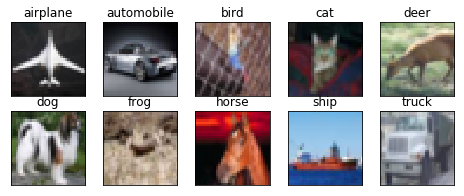

In [4]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [11]:
# Define the model
from keras import regularizers
from keras.layers import Input
from keras.layers.merge import concatenate
from keras.models import Model
from keras.layers.convolutional import DepthwiseConv2D

visible = Input(shape=(32,32,3)) 

conv1 = Conv2D(16, 3, 3, kernel_regularizer=regularizers.l2(0.0001), border_mode = 'same')(visible) # 32, 3
conv1 = BatchNormalization()(conv1)
conv1 = Activation('relu')(conv1)
conv1 = Dropout(0.10)(conv1)

conv1 = Conv2D(16, 3, 3, kernel_regularizer=regularizers.l2(0.0001))(conv1) # 32, 3
conv1 = BatchNormalization()(conv1)
conv1 = Activation('relu')(conv1)
conv1 = Dropout(0.10)(conv1)

conv2 = Conv2D(32, 1, 3, kernel_regularizer=regularizers.l2(0.0001))(conv1) # 30, 5
conv2 = BatchNormalization()(conv2)
conv2 = Activation('relu')(conv2)
conv2 = Dropout(0.10)(conv2)

conv3 = Conv2D(32, 3, 1, kernel_regularizer=regularizers.l2(0.0001))(conv2) # 30, 28, 5, 7
conv3 = BatchNormalization()(conv3)
conv3 = Activation('relu')(conv3)
conv3 = Dropout(0.10)(conv3)

conv4 = DepthwiseConv2D(3, 3, depth_multiplier=2, kernel_regularizer=regularizers.l2(0.0001))(conv3) # 28, 7
conv4 = BatchNormalization()(conv4)
conv4 = Activation('relu')(conv4)
conv4 = Dropout(0.10)(conv4)

group_conv1 = Conv2D(128, 3, 3, kernel_regularizer=regularizers.l2(0.0001))(conv4) # 9, 21 
group_conv1 = BatchNormalization()(group_conv1)
group_conv1 = Activation('relu')(group_conv1)
group_conv1 = Dropout(0.10)(group_conv1)

group_conv1 = Conv2D(128, 3, 3, kernel_regularizer=regularizers.l2(0.0001))(group_conv1) # 7, 23
group_conv1 = BatchNormalization()(group_conv1)
group_conv1 = Activation('relu')(group_conv1)
group_conv1 = Dropout(0.10)(group_conv1)

group_conv2 = Conv2D(128, 5, 5, kernel_regularizer=regularizers.l2(0.0001))(conv4) # 9, 21
group_conv2 = BatchNormalization()(group_conv2)
group_conv2 = Activation('relu')(group_conv2)
group_conv2 = Dropout(0.10)(group_conv2)

merge1 = concatenate([group_conv1, group_conv2]) # 5, 25

group_conv3 = Conv2D(256, 3, 3, kernel_regularizer=regularizers.l2(0.0001), dilation_rate = 1, border_mode = 'same')(merge1) # 5, 25
group_conv3 = BatchNormalization()(group_conv3)
group_conv3 = Activation('relu')(group_conv3)
group_conv3 = Dropout(0.10)(group_conv3)

group_conv4 = Conv2D(256, 3, 3, kernel_regularizer=regularizers.l2(0.0001), dilation_rate = 2, border_mode = 'same')(merge1) # 5, 25
group_conv4 = BatchNormalization()(group_conv4)
group_conv4 = Activation('relu')(group_conv4)
group_conv4 = Dropout(0.10)(group_conv4)

merge2 = concatenate([group_conv3, group_conv4]) #5, 29

conv5 = Conv2D(10, 1, 1, kernel_regularizer=regularizers.l2(0.0001))(merge2) # 5, 29
conv5 = BatchNormalization()(conv5)
conv5 = Activation('relu')(conv5)
conv5 = Dropout(0.10)(conv5)

conv6 = Conv2D(10, 5, 5)(conv5) # 2, 29

conv6 = Flatten()(conv6)
output = Activation('softmax')(conv6)

model = Model(inputs=visible, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Input() is used to instantiate a Keras tensor.A Keras tensor is a tensor object from the underlying backend (TensorFlow),
# which we augment with certain attributes that allow us to build a Keras model just by knowing the inputs and outputs of the model.
# For instance, if a, b and c are Keras tensors, it becomes possible to do -  model = Model(input=[a, b], output=c).
# In the functional API, Model() instantiates some input tensor(s) and output tensor(s).
# cancatenate() is a layer that concatenates a list of inputs.It takes as input a list of tensors, all of the same shape 
# except for the concatenation axis, and returns a single tensor, the concatenation of all inputs.
# DepthwiseConv2D() - Depthwise Separable convolutions consists in performing just the first step in a depthwise spatial convolution 
# (which acts on each input channel separately).
# The depth_multiplier argument controls how many output channels are generated per input channel in the depthwise step.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), kernel_regularizer=<keras.reg...)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 3), kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 1), kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher

In [12]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 32, 32, 16)   448         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_11 (BatchNo (None, 32, 32, 16)   64          conv2d_11[0][0]                  
__________________________________________________________________________________________________
activation_12 (Activation)      (None, 32, 32, 16)   0           batch_normalization_11[0][0]     
__________________________________________________________________________________________________
dropout_11

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=50)`
  if sys.path[0] == '':


Epoch 1/50
390/390 [==============================] - 21s 55ms/step - loss: 1.5688 - acc: 0.4644 - val_loss: 1.5680 - val_acc: 0.5023
Epoch 2/50
390/390 [==============================] - 18s 46ms/step - loss: 1.1326 - acc: 0.6354 - val_loss: 1.2725 - val_acc: 0.5923
Epoch 3/50
390/390 [==============================] - 18s 46ms/step - loss: 0.9623 - acc: 0.7056 - val_loss: 1.1452 - val_acc: 0.6586
Epoch 4/50
390/390 [==============================] - 18s 46ms/step - loss: 0.8595 - acc: 0.7466 - val_loss: 0.9450 - val_acc: 0.7289
Epoch 5/50
390/390 [==============================] - 18s 46ms/step - loss: 0.8055 - acc: 0.7689 - val_loss: 0.8842 - val_acc: 0.7451
Epoch 6/50
390/390 [==============================] - 18s 46ms/step - loss: 0.7617 - acc: 0.7882 - val_loss: 0.9561 - val_acc: 0.7435
Epoch 7/50
390/390 [==============================] - 18s 46ms/step - loss: 0.7252 - acc: 0.8062 - val_loss: 1.0223 - val_acc: 0.7221
Epoch 8/50
390/390 [==============================] - 18s 46ms

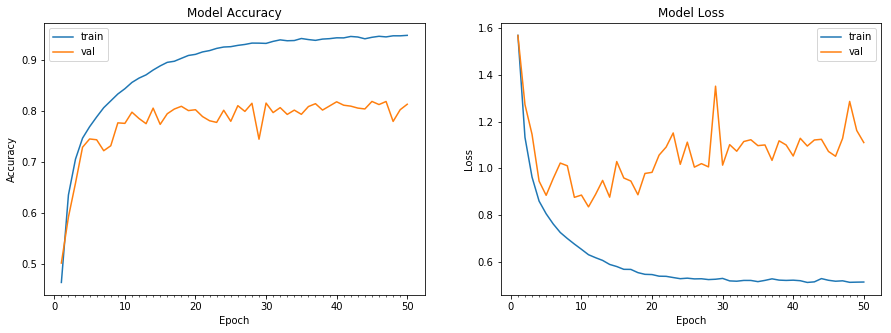

Accuracy on test data is: 81.30


In [13]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))


1. The first two normal convolutional layers are of kernel size 3x3. The first layer has padding = same, while the second doesnt.
2. This is followed by a spatially seperable layers, that is a convolutional layer of kernel size of 1x3 and then a convolutional layer with kernel size of 3x1.
3. The next layer is a Depthwise Seperable convolution with depth multiplier given as 2 , such that the number of output channels is doubled than the previous layer. It also reduces the input image size 3 times than its original size.
4. The output of the above layer is given to two convloutional layers with kernel size 3x3 and 5x5 respectively. Plus one more convolutional layer with 3x3 is added to the to the first one, so as to make both the outputs of 3x3 and 5x5 same. This is meged together using concatenate.
5. The output of the above concatenation is passed to two convolutional layers with kernel size 3x3 but with dilation_rate 1 and 2 repectively. The padding here is same.
6. This is followed a 1x1 convolution layer to reduce the number of channels from 512 to 10.
7. Finally a 5x5 convolutional layer followed by a Flatten() layer , and then the output is passed to the Softmax layer for prediction.
8. Running the model for 50 epochs , i got a training accuracy of 94.77%and a validation accuracy of 81.30%.